<center><h1> Capsule Networks for Digit Recognition in PyTorch</h1></center>


We are going to implement the Capsule Network from Prof. Hinton's paper on [Dynamic Routing Between Capsules](https://arxiv.org/pdf/1710.09829.pdf). The network consists of the novel Primary and Digit Caps Layers which perform nested convolutions. Dynamic routing, or more specifically Routing by Agreement, takes place in the Digit Caps Capsule Layer which we will discuss in more detail. So let's get started and begin with or standard imports from the PyTorch module. 

## 1. Import Dependencies

In [0]:
#Import dependencies
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.optim import lr_scheduler
from torch.autograd import Variable
import matplotlib.pyplot as plt

#Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## 2. Define the Squash Function

Caspule layers make use of a different squashing non-linearity than softmax and sigmoid. This function is called the squash function. This enables us to represent the length of the outut vector from the capsule as a probability. This probability indicates the presence of entity represented by capsule in the input. The squashing function can be mathematically expressed as-

<center> $v_{j} = \frac{||s_{j}^{2}||}{||1 + s_{j}^{2}||} \frac{s_{j}}{||s_{j}||}$</center>

Here, $v_{j}$ is the vector output from the capsule and $s_{j}$ is its total input. For all but the first layer capsules, The total input is the weighted sum of all the prediction vectors $\hat{u}_{j|i}$ from all the capsule layers in the layer below. This can be mathematically expressed as-
<center>$s_{j} = \sum_{i}c_{ij}\hat{u}_{j|i}$</center>




In [0]:
def squash(x):
    lengths2 = x.pow(2).sum(dim=2)
    lengths = lengths2.sqrt()
    x = x * (lengths2 / (1 + lengths2) / lengths).view(x.size(0), x.size(1), 1)
    return x

## 3. Routing Mechanism

The dynamic routing mechanism is implemented between capsule layers and works on the basis of routing softmax, whose inputs are initial logits $b_{ij}$. These are the log probabilities that capsule i should be coupled to capsule j. 

<center>$ c_{ij} = \frac{exp(b_{ij})}{\sum_{k}exp(b_{ik})}$</center>

Now, the agreement between two capsule layers is simply defined as $a_{ij} = v_{j}.\hat{u}_{j|i}$. This agreement is treated as if it was a log
likelihood and is added to the initial logit, $b_{ij}$ before computing the new values for all the coupling coefficients linking capsule i to higher level capsules.

In convolutional capsule layers, each capsule outputs a local grid of vectors to each type of capsule in the layer above using different transformation matrices for each member of the grid as well as for
each type of capsule.

The main idea here is that the iterative process is repeated for a fixed number of times. Once the capsule j corresponding to capsule i is determined with maximum agreement, information is passed to capsule j. In order to understand the algorithm completely, you are encouraged to read the paper. 

In [0]:
class AgreementRouting(nn.Module):
    def __init__(self, input_caps, output_caps, n_iterations):
        super(AgreementRouting, self).__init__()
        self.n_iterations = n_iterations
        self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))
    
    def forward(self, u_predict):
        batch_size, input_caps, output_caps, output_dim = u_predict.size()

        c = F.softmax(self.b) #softmax routing
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = squash(s)

        #iterate over capsules for a fixed number of iterations
        if self.n_iterations > 0:
            b_batch = self.b.expand((batch_size, input_caps, output_caps))
            for r in range(self.n_iterations):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
                s = (c * u_predict).sum(dim=1)
                v = squash(s)

        return v

## 4. Capsule Layer

We will now construct the Capsule layer. This is the layer wherein the routing takes place. Prediction $\hat{u}_{j|i}$ is obtained from the previous layer, reshaped and passed to the routing mechanism. 

Input to the Capsule layer is the squashed 3 dimensional array obtained from the previous Capsule layer which we will discuss in the next section. The routing mechanism in the Capsule layer returns the output capsule vector v.

In [0]:
class CapsLayer(nn.Module):
    def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
        super(CapsLayer, self).__init__()
        self.input_dim = input_dim
        self.input_caps = input_caps
        self.output_dim = output_dim
        self.output_caps = output_caps
        self.weights = nn.Parameter(torch.Tensor(input_caps, input_dim, output_caps * output_dim))
        self.routing_module = routing_module
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.input_caps)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(u_predict.size(0), self.input_caps, self.output_caps, self.output_dim)
        v = self.routing_module(u_predict)
        return v

## 5. Primary Capsule Layer

The primary capsule layer, also known as PrimaryCaps layer, is the first layer consisting of nested convolutions. The layer is followed by a convolution layer at the input. The layer then links to the main Capsule layer. 

Output to the primary capsule layer is a 3 dimensional vector $[batch\_size,out\_caps,out\_dim]$ wherein 'out_caps' is the output capsules, i.e- the number of capsules in the next layer and 'out_dim' is the dimension of output capsules. 

In [0]:
class PrimaryCapsLayer(nn.Module):
    def __init__(self, input_channels, output_caps, output_dim, kernel_size, stride):
        super(PrimaryCapsLayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_caps * output_dim, kernel_size=kernel_size, stride=stride)
        self.input_channels = input_channels
        self.output_caps = output_caps
        self.output_dim = output_dim

    def forward(self, input):
        out = self.conv(input)
        N, C, H, W = out.size()
        out = out.view(N, self.output_caps, self.output_dim, H, W)

        # will output N x OUT_CAPS x OUT_DIM
        out = out.permute(0, 1, 3, 4, 2).contiguous()
        out = out.view(out.size(0), -1, out.size(4))
        out = squash(out)
        return out

## 6. Assemble Layers to construct the network

And here we are! Now we can assemble all our layers in the correct order to construc the Capsule Network. Starting from the top-  
$\rightarrow$A 2d convolution layer, $Conv2d$.  

$\rightarrow$The primary Capsule Layer, $PrimaryCapsLayer$ with its arguments as $input\_channels, output\_caps, output\_dim, kernel\_size, stride$.  

$\rightarrow$The Capsule Layer, $CapsLayer$ with the arguments $input\_caps, input\_dim, output\_caps, output\_dim, routing\_module$. This is the layer where the routing takes place, i.e- set the argument $routing\_module$ to $'Agreement Routing'$ which takes in the arguments $num\_primaryCaps, n\_classes, routing\_iterations$.  

$\rightarrow$Fully-connected layers using $Linear$ with ReLU and Sigmoid activations. 

In [0]:
class CapsNet(nn.Module):
    def __init__(self, routing_iterations, n_classes=10):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primaryCaps = PrimaryCapsLayer(256, 32, 8, kernel_size=9, stride=2)  # outputs 6*6
        self.num_primaryCaps = 32 * 6 * 6
        routing_module = AgreementRouting(self.num_primaryCaps, n_classes, routing_iterations)
        self.digitCaps = CapsLayer(self.num_primaryCaps, 8, n_classes, 16, routing_module)
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(n_dim * n_classes, 512)
        # self.fc2 = nn.Linear(512, 1024)
        # self.fc3 = nn.Linear(1024,784)

    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        # x = self.flatten(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.sigmoid(self.fc3(x))
        return x, probs

## 7. Initialize Margin Loss

We deviate from our standard loss metrics for this tutorial and try out a new loss function called the Margin Loss. The reason behind this is that we wish to assess the capsule vector instantiation corresponding to eah digit. This is because we are using the length of the instantiation vector to represent the probability that a capule's entity exists. Thus, we would like to the top level capsule for digit class 'k' to have higher instantiation if the digit is present in the image.  

Margin Loss can be mathematically expressed as-  
<center>$L_{k} = T_{k} max(0,m^{+} - ||v_{k}||)^{2} + \lambda(1 - T_{k})max(0,||v_{k}|| - m^{-})^{2}$ </center>


Here, $T_{k} = 1$ if a digit of class 'k' is present, $m^{+} = 0.9$ and $m^{-} = 0.1$. $\lambda$ is used as a donw-weighting constant of the loss for absent digit classes This stops the initial learning from shrinking the lengths of activity vectors of all digit capsules.  

In [0]:
class MarginLoss(nn.Module):
    def __init__(self, m_pos, m_neg, lambda_):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, lengths, targets, size_average=True):
        t = torch.zeros(lengths.size()).long()
        if targets.is_cuda:
            t = t.cuda()
        t = t.scatter_(1, targets.data.view(-1, 1), 1)
        targets = Variable(t)
        losses = targets.float() * F.relu(self.m_pos - lengths).pow(2) + \
                 self.lambda_ * (1. - targets.float()) * F.relu(lengths - self.m_neg).pow(2)
        return losses.mean() if size_average else losses.sum()

## 8. Train and Test the Model

All right, now we are all setup to start training our CapsNet. We can load the MNIST dataset from PyTorch and load the data in the 'DataLoader' (as we did in the previous tutorials). 

In [16]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

batch_size = 128
test_batch_size = 100
epochs = 10
routing_iterations = 3
lr = 0.001
loss_train = []
loss_test = []

#Load training data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2), transforms.RandomCrop(28),
                        transforms.ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

#Load testing data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])),
    batch_size=test_batch_size, shuffle=False)

#Initialize model and training paramters
model = CapsNet(routing_iterations).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=15, min_lr=1e-6)
loss_fn = MarginLoss(0.9, 0.1, 0.5)

#Train the model
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target, requires_grad=False).to(device)
        optimizer.zero_grad()
        output, probs = model(data)
        loss = loss_fn(probs, target)
        loss.backward()
        optimizer.step()
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
        loss_train.append(loss.item())
        
#Test the model
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data, target = Variable(data, volatile=True), Variable(target)
        output, probs = model(data)
        test_loss += loss_fn(probs, target, size_average=False).item()

        pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

#Iterate over epochs
for epoch in range(1, epochs + 1):
        train(epoch)
        test_loss = test()
        loss_test.append(test_loss)
        scheduler.step(test_loss)
        torch.save(model.state_dict(),
                   '{:03d}_model_dict_{}.pth'.format(epoch, routing_iterations))
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.080879
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.006140
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.005142
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.001950


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 0.0244, Accuracy: 9839/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.003473
Train Epoch: 2 [16384/60000 (27%)]	Loss: 0.002214
Train Epoch: 2 [32768/60000 (55%)]	Loss: 0.001916
Train Epoch: 2 [49152/60000 (82%)]	Loss: 0.002433

Test set: Average loss: 0.0170, Accuracy: 9898/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.002062
Train Epoch: 3 [16384/60000 (27%)]	Loss: 0.001276
Train Epoch: 3 [32768/60000 (55%)]	Loss: 0.001528
Train Epoch: 3 [49152/60000 (82%)]	Loss: 0.001160

Test set: Average loss: 0.0095, Accuracy: 9932/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001378
Train Epoch: 4 [16384/60000 (27%)]	Loss: 0.001322
Train Epoch: 4 [32768/60000 (55%)]	Loss: 0.002625
Train Epoch: 4 [49152/60000 (82%)]	Loss: 0.001617

Test set: Average loss: 0.0116, Accuracy: 9921/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.001244
Train Epoch: 5 [16384/60000 (27%)]	Loss: 0.002248
Train Epoch: 5 [32768/60000 (55%)]	Loss: 0.000965
Train Epoch: 5 [49152/6000

Text(0, 0.5, 'Loss')

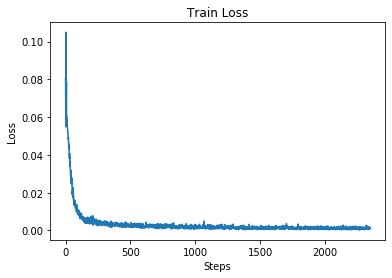

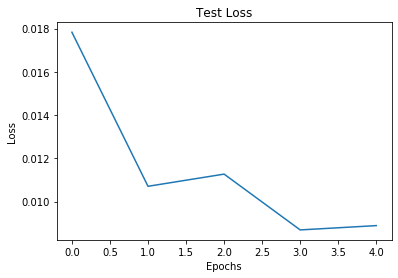

In [11]:
#Train Loss
plt.figure()
plt.title('Train Loss')
plt.plot(loss_train)
plt.xlabel('Steps')
plt.ylabel('Loss')

#Test Loss
#Plot results
plt.figure()
plt.title('Test Loss')
plt.plot(loss_test)
plt.xlabel('Epochs')
plt.ylabel('Loss')